In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"krishna5701","key":"8938ca8d9d1446c4ad88b8c7de54ca98"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d nodoubttome/skin-cancer9-classesisic --unzip --force

100% 786M/786M [00:35<00:00, 25.1MB/s]
100% 786M/786M [00:35<00:00, 23.3MB/s]


In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam # - Works
import random
from glob import glob
import seaborn as sns
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
import matplotlib.image as img
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
! rm -rf /kaggle/working/data/

In [ ]:
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


Prepare Dataset


In [ ]:
batch_size = 32
img_height = 180
img_width = 180
rnd_seed = 123
IMG_INPUT_SHAPE  = (180, 180, 3)
random.seed(rnd_seed)

In [ ]:
!find . -name ".ipynb_checkpoints" -type d -exec rm -rf {} +

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.9,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 106 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


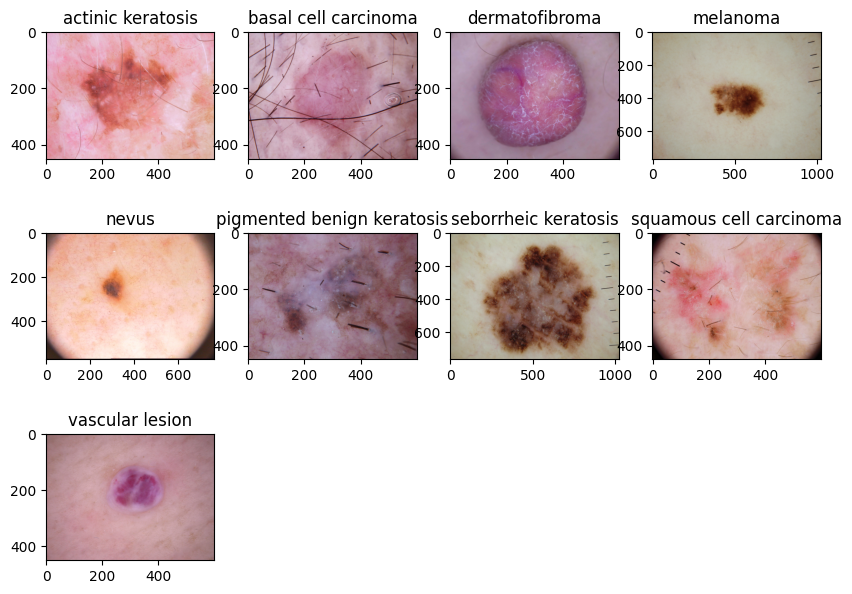

In [ ]:
num_classes = len(class_names)
plt.figure(figsize=(10,10))
for i in range(num_classes):
  plt.subplot(4,4,i+1)
  image = img.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)


In [ ]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes = 10
model = Sequential([layers.experimental.preprocessing.Rescaling \
                    (1.0/255,input_shape=(img_height,img_width,3))])

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())


model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))

In [ ]:
opt = Adam(lr=0.001)
model.compile(optimizer= opt,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.preprocessing import image

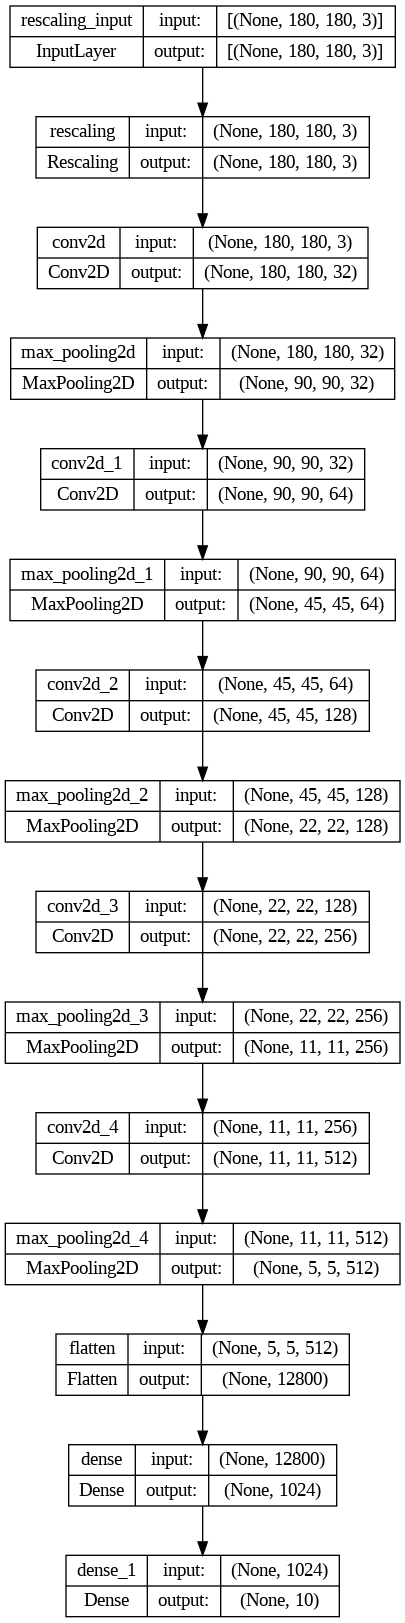

In [ ]:
image_path = "model_layers.png"
tf.keras.utils.plot_model(model, to_file=image_path, show_shapes=True)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

In [ ]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
56/56 [==============================] - 30s 110ms/step - loss: 2.1127 - accuracy: 0.1987 - val_loss: 2.0327 - val_accuracy: 0.1924
Epoch 2/25
56/56 [==============================] - 2s 41ms/step - loss: 1.9886 - accuracy: 0.2143 - val_loss: 2.0630 - val_accuracy: 0.2841
Epoch 3/25
56/56 [==============================] - 2s 41ms/step - loss: 1.8632 - accuracy: 0.3013 - val_loss: 1.7243 - val_accuracy: 0.3669
Epoch 4/25
56/56 [==============================] - 2s 41ms/step - loss: 1.6734 - accuracy: 0.3962 - val_loss: 1.7080 - val_accuracy: 0.3356
Epoch 5/25
56/56 [==============================] - 2s 44ms/step - loss: 1.6486 - accuracy: 0.4263 - val_loss: 1.5475 - val_accuracy: 0.4765
Epoch 6/25
56/56 [==============================] - 2s 42ms/step - loss: 1.5945 - accuracy: 0.4347 - val_loss: 1.5363 - val_accuracy: 0.4743
Epoch 7/25
56/56 [==============================] - 2s 41ms/step - loss: 1.4970 - accuracy: 0.4833 - val_loss: 1.4984 - val_accuracy: 0.4899
Epoch 8/25


In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# assuming you have a test dataset with true labels and predicted labels
test_labels = []
for images, labels in val_ds:
    test_labels.extend(labels.numpy())

# make predictions on the test dataset using the trained model
predicted_labels = model.predict(test_ds)

# convert predicted labels to one-hot encoded format
predicted_labels_one_hot = np.argmax(predicted_labels, axis=1)

# generate the classification report
class_names = ["class_" + str(i) for i in range(num_classes)]
report = classification_report(test_labels, predicted_labels_one_hot, target_names=class_names)

# print the classification report
print(report)

NameError: ignored

In [ ]:
model.save('model.h5')

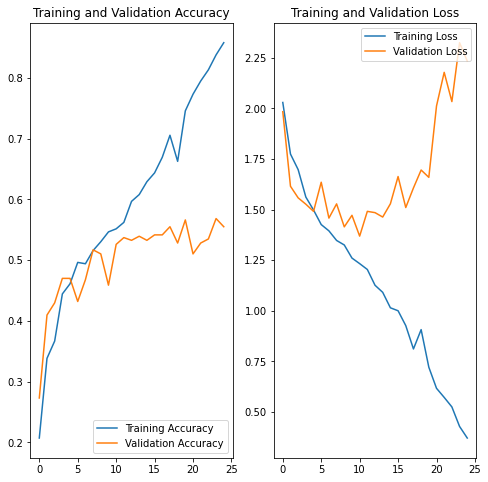

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Data Augmentation And Dropout layer 


In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

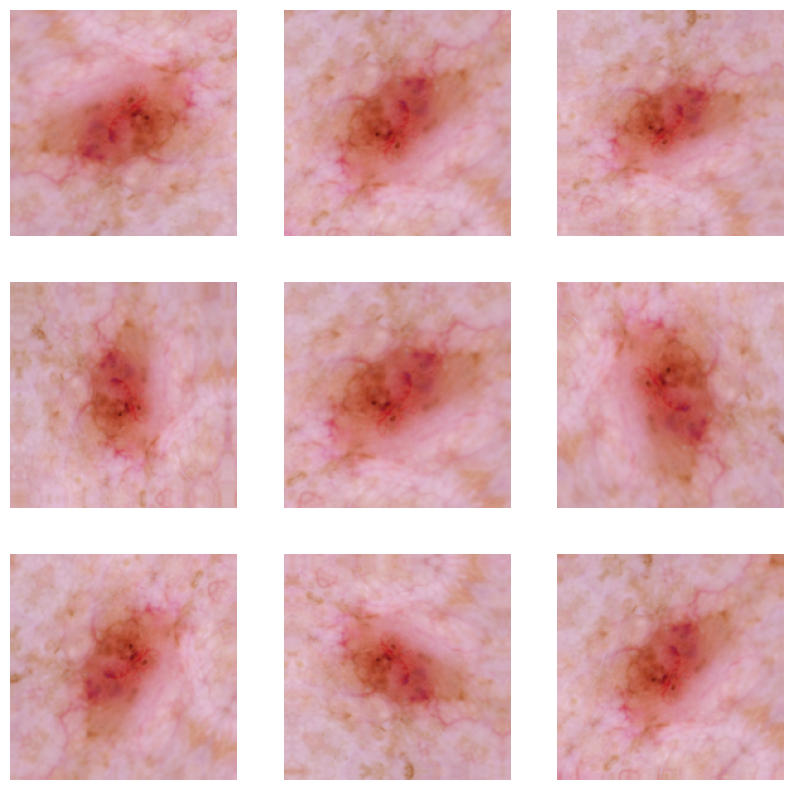

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
num_classes = 9
model = Sequential(data_augmentation)
model.add(layers.experimental.preprocessing.Rescaling(1.0/255,input_shape=(img_height,img_width,3)))

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.15))

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.20))

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))

Imbalance data handling


total training image count = 2239 

-------------------------------------
Class name =  actinic keratosis
count      =  114
proportion =  0.05091558731576597
-------------------------------------
Class name =  basal cell carcinoma
count      =  376
proportion =  0.16793211255024565
-------------------------------------
Class name =  dermatofibroma
count      =  95
proportion =  0.04242965609647164
-------------------------------------
Class name =  melanoma
count      =  438
proportion =  0.19562304600267977
-------------------------------------
Class name =  nevus
count      =  357
proportion =  0.15944618133095131
-------------------------------------
Class name =  pigmented benign keratosis
count      =  462
proportion =  0.20634211701652524
-------------------------------------
Class name =  seborrheic keratosis
count      =  77
proportion =  0.03439035283608754
-------------------------------------
Class name =  squamous cell carcinoma
count      =  181
proportion =  0.08083966056

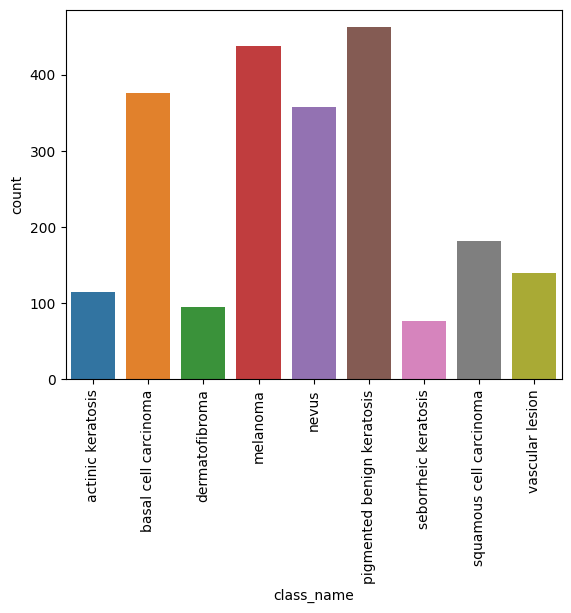

In [ ]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])

temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

Highly Imbalance 
Augmentor : Class Balance


In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
path_to_training_dataset = '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i, output_directory='/kaggle/working/data/'+i+'/output/')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000) 

Initialised with 114 image(s) found.
Output directory set to /kaggle/working/data/actinic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F26302DBF40>: 100%|██████████| 1000/1000 [00:48<00:00, 20.61 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /kaggle/working/data/basal cell carcinoma/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F263031E650>: 100%|██████████| 1000/1000 [00:43<00:00, 22.80 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /kaggle/working/data/dermatofibroma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2630674A60>: 100%|██████████| 1000/1000 [00:37<00:00, 26.61 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /kaggle/working/data/melanoma/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F26305D4A30>: 100%|██████████| 1000/1000 [03:12<00:00,  5.20 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /kaggle/working/data/nevus/output/.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7F2631A551B0>: 100%|██████████| 1000/1000 [02:56<00:00,  5.67 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /kaggle/working/data/pigmented benign keratosis/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F263040B910>: 100%|██████████| 1000/1000 [00:36<00:00, 27.53 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /kaggle/working/data/seborrheic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F2631965C30>: 100%|██████████| 1000/1000 [01:27<00:00, 11.36 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /kaggle/working/data/squamous cell carcinoma/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F26302D8FD0>: 100%|██████████| 1000/1000 [00:36<00:00, 27.67 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /kaggle/working/data/vascular lesion/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F263040B850>: 100%|██████████| 1000/1000 [00:37<00:00, 26.85 Samples/s]


In [ ]:
output_dir = pathlib.Path('/kaggle/working/data/')
image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
print(image_count_train)

9000


total training image count = 9000 

-------------------------------------
Class name =  actinic keratosis
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  basal cell carcinoma
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  dermatofibroma
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  melanoma
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  nevus
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  pigmented benign keratosis
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  seborrheic keratosis
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  squamous cell carcinoma
count      =  1000
proportion =  0.11111111

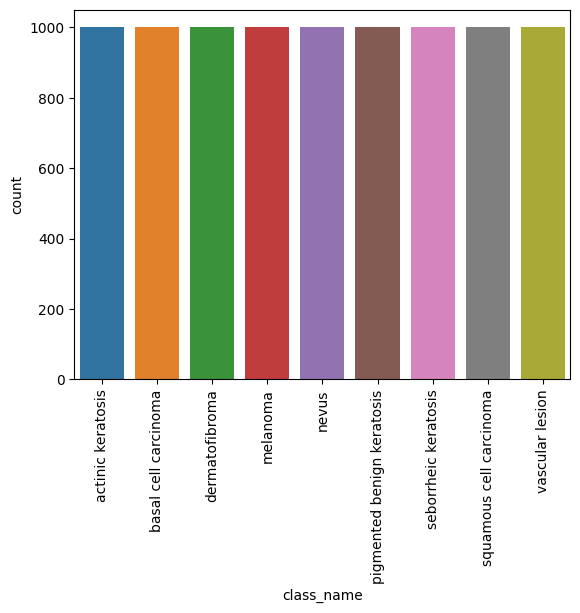

In [ ]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []

for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])


temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9000 files belonging to 9 classes.
Using 7200 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9000 files belonging to 9 classes.
Using 1800 files for validation.


In [ ]:
def get_model(tf_model):
    model = None
    if tf_model == "VGG16":
        model = tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_tensor = tf.keras.Input(shape=IMG_INPUT_SHAPE))
    elif tf_model == "ResNet50":
        model = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_tensor = tf.keras.Input(shape=IMG_INPUT_SHAPE))
    elif tf_model == "MobileNetV2":
        model = tf.keras.applications.MobileNetV2(include_top=False, weights="imagenet", input_tensor = tf.keras.Input(shape=IMG_INPUT_SHAPE))
    else:
        raise Exception('SUNXYZ', 'Model unknown')
    return_model = tf.keras.models.Sequential()
    return_model.add(model)
    return_model.add(tf.keras.layers.Flatten())
    return_model.add(tf.keras.layers.Dense(512))
    return_model.add(tf.keras.layers.Dense(256, activation='relu'))
    return_model.add(tf.keras.layers.Dense(64, activation='relu'))
    return_model.add(tf.keras.layers.Dense(9, activation='softmax'))
    return return_model


In [ ]:
BASIC_MODEL = tf.keras.models.Sequential()
BASIC_MODEL.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
BASIC_MODEL.add(tf.keras.layers.MaxPooling2D((2, 2)))
BASIC_MODEL.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
BASIC_MODEL.add(tf.keras.layers.MaxPooling2D((2, 2)))
BASIC_MODEL.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
BASIC_MODEL.add(tf.keras.layers.Flatten())
BASIC_MODEL.add(tf.keras.layers.Dense(256, activation='relu'))
BASIC_MODEL.add(tf.keras.layers.Dense(64, activation='relu'))
BASIC_MODEL.add(tf.keras.layers.Dense(9, activation='softmax'))

In [ ]:
VGG16_MODEL       = get_model("VGG16")
RESNET50_MODEL    = get_model("ResNet50")
MOBILENETv2_MODEL = get_model("MobileNetV2")

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
VGG16_MODEL.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0         
                                                                 
 dense_3 (Dense)             (None, 512)               6554112   
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dense_5 (Dense)             (None, 64)                16448     
                                                                 
 dense_6 (Dense)             (None, 2)                 130       
                                                                 
Total params: 21,416,706
Trainable params: 21,416,706


In [ ]:
RESNET50_MODEL.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 73728)             0         
                                                                 
 dense_7 (Dense)             (None, 512)               37749248  
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 dense_9 (Dense)             (None, 64)                16448     
                                                                 
 dense_10 (Dense)            (None, 2)                 130       
                                                                 
Total params: 61,484,866
Trainable params: 61,431,746


In [ ]:
MOBILENETv2_MODEL.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_3 (Flatten)         (None, 46080)             0         
                                                                 
 dense_11 (Dense)            (None, 512)               23593472  
                                                                 
 dense_12 (Dense)            (None, 256)               131328    
                                                                 
 dense_13 (Dense)            (None, 64)                16448     
                                                                 
 dense_14 (Dense)            (None, 2)                 130       
                                                      

In [ ]:
def compile_and_fit(model):
    model.compile(optimizer='adam',
      loss=tf.losses.SparseCategoricalCrossentropy(),
      metrics=['accuracy'])
    history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=10
    )
    return history

In [ ]:
VGG16_HISTORY = compile_and_fit(VGG16_MODEL)

Epoch 1/10
225/225 [==============================] - 96s 315ms/step - loss: nan - accuracy: 0.1112 - val_loss: nan - val_accuracy: 0.1100
Epoch 2/10
225/225 [==============================] - 66s 291ms/step - loss: nan - accuracy: 0.1114 - val_loss: nan - val_accuracy: 0.1100
Epoch 3/10
225/225 [==============================] - 67s 294ms/step - loss: nan - accuracy: 0.1114 - val_loss: nan - val_accuracy: 0.1100
Epoch 4/10
225/225 [==============================] - 67s 294ms/step - loss: nan - accuracy: 0.1114 - val_loss: nan - val_accuracy: 0.1100
Epoch 5/10
225/225 [==============================] - 67s 293ms/step - loss: nan - accuracy: 0.1114 - val_loss: nan - val_accuracy: 0.1100
Epoch 6/10
225/225 [==============================] - 66s 292ms/step - loss: nan - accuracy: 0.1114 - val_loss: nan - val_accuracy: 0.1100
Epoch 7/10
225/225 [==============================] - 67s 293ms/step - loss: nan - accuracy: 0.1114 - val_loss: nan - val_accuracy: 0.1100
Epoch 8/10
225/225 [=======

In [ ]:
VGG16_MODEL.save('vgg16_model.h5')

In [ ]:
num_classes = 9
model3 = Sequential([layers.experimental.preprocessing.Rescaling(1.0/255,input_shape=(img_height,img_width,3))])

model3.add(Conv2D(32, 3,padding="same",activation='relu'))
model3.add(MaxPool2D())

model3.add(Conv2D(64, 3,padding="same",activation='relu'))
model3.add(MaxPool2D())

model3.add(Conv2D(128, 3,padding="same",activation='relu'))
model3.add(MaxPool2D())
model3.add(Dropout(0.15))

model3.add(Conv2D(256, 3,padding="same",activation='relu'))
model3.add(MaxPool2D())
model3.add(Dropout(0.20))

model3.add(Conv2D(512, 3,padding="same",activation='relu'))
model3.add(MaxPool2D())
model3.add(Dropout(0.25))

model3.add(Flatten())
model3.add(Dense(1024,activation="relu"))
model3.add(Dense(units=num_classes, activation= 'softmax'))

In [ ]:
from tensorflow.keras.preprocessing import image

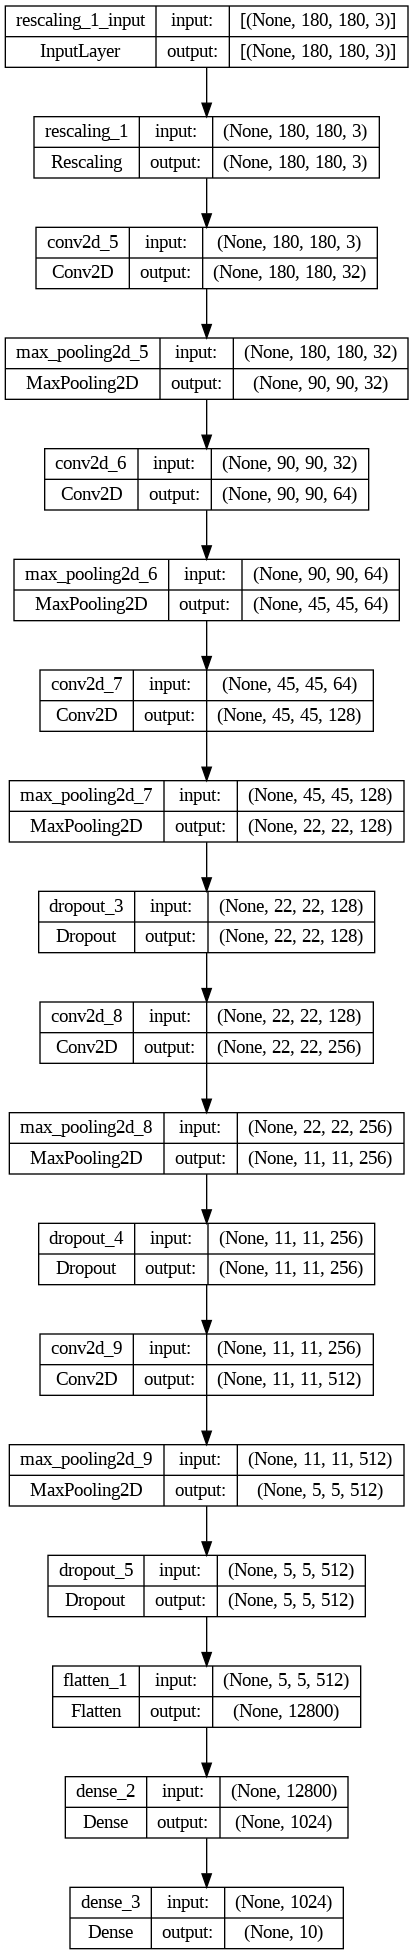

In [ ]:
image_path = "model_layers.png"
tf.keras.utils.plot_model(model3, to_file=image_path, show_shapes=True)

In [ ]:
opt = Adam(lr=0.001)
model.compile(optimizer= opt,
              loss = SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
225/225 [==============================] - 27s 117ms/step - loss: 0.8161 - accuracy: 0.6875 - val_loss: 0.7815 - val_accuracy: 0.6989
Epoch 2/25
225/225 [==============================] - 28s 120ms/step - loss: 0.8090 - accuracy: 0.6886 - val_loss: 0.7642 - val_accuracy: 0.7128
Epoch 3/25
225/225 [==============================] - 27s 117ms/step - loss: 0.8117 - accuracy: 0.6853 - val_loss: 0.7441 - val_accuracy: 0.7211
Epoch 4/25
225/225 [==============================] - 26s 114ms/step - loss: 0.8077 - accuracy: 0.6935 - val_loss: 0.7478 - val_accuracy: 0.7061
Epoch 5/25
225/225 [==============================] - 27s 116ms/step - loss: 0.7585 - accuracy: 0.7063 - val_loss: 0.8042 - val_accuracy: 0.6883
Epoch 6/25
225/225 [==============================] - 27s 116ms/step - loss: 0.7284 - accuracy: 0.7179 - val_loss: 0.8066 - val_accuracy: 0.6939
Epoch 7/25
225/225 [==============================] - 28s 118ms/step - loss: 0.7171 - accuracy: 0.7283 - val_loss: 0.7396 - val_ac

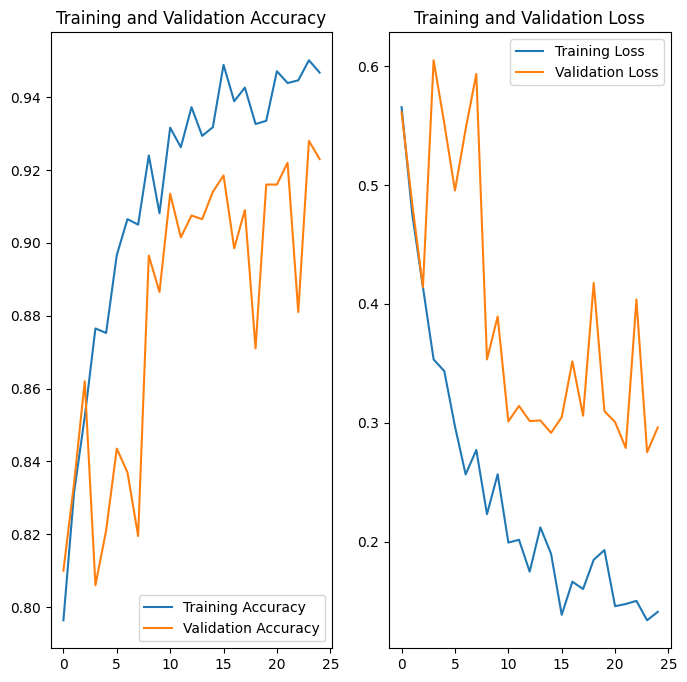

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save('model.h5')

In [ ]:
from google.colab import files
files.download("model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

EXAI

In [ ]:
pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283859 sha256=bdc0d1ba06708b32ef04fa5dd5f79fabfbdcefebe19dd98dcd8f15987bb24c50
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
from lime import lime_image
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model('model.h5')

# Create the explainer object
explainer = lime_image.LimeImageExplainer()

In [ ]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing import image
import PIL.Image

IMAGE 1

In [ ]:
from PIL import Image

# Open the input image
input_image = Image.open('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/NonSkin Cancer/pic 1 (14).jpg')

# Resize the image to 256x256
output_image = input_image.resize((180, 180))

# Save the output image
output_image.save('output_image.png')


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


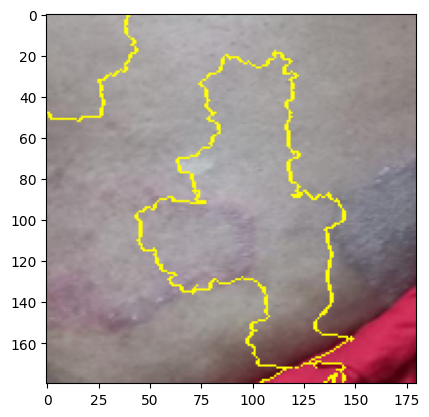

In [ ]:
from skimage.segmentation import mark_boundaries

# Load the image
fp = open("output_image.png","rb")
img = PIL.Image.open(fp)

# Preprocess the image for the model
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

# Get the explanation for the prediction
explanation = explainer.explain_instance(img_array, model.predict, top_labels=5, hide_color=0, num_samples=1000)

# Create a visualization of the explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp / 2 + 0.5, mask)

plt.imshow(img_boundry1)
plt.show()

Image 2

In [ ]:
from PIL import Image

# Open the input image
input_image = Image.open('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0026040.jpg')

# Resize the image to 256x256
output_image = input_image.resize((180, 180))

# Save the output image
output_image.save('output_image2.png')

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


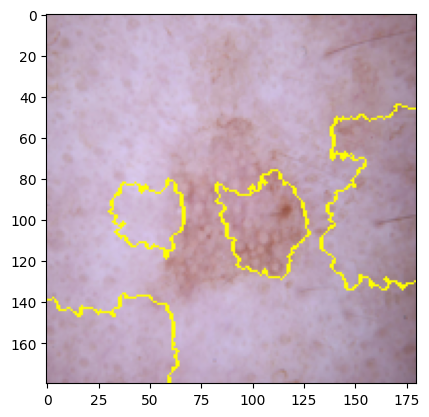

In [ ]:
from skimage.segmentation import mark_boundaries

# Load the image
fp = open("output_image2.png","rb")
img = PIL.Image.open(fp)

# Preprocess the image for the model
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

# Get the explanation for the prediction
explanation = explainer.explain_instance(img_array, model.predict, top_labels=5, hide_color=0, num_samples=1000)

# Create a visualization of the explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp / 2 + 0.5, mask)

plt.imshow(img_boundry1)
plt.show()

IMAGE 3

In [ ]:
from PIL import Image

# Open the input image
input_image = Image.open('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/ISIC_0025793.jpg')

# Resize the image to 256x256
output_image = input_image.resize((180, 180))

# Save the output image
output_image.save('output_image3.png')

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


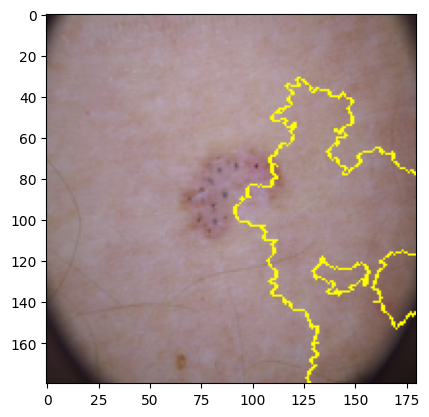

In [ ]:
from skimage.segmentation import mark_boundaries

# Load the image
fp = open("output_image3.png","rb")
img = PIL.Image.open(fp)

# Preprocess the image for the model
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

# Get the explanation for the prediction
explanation = explainer.explain_instance(img_array, model.predict, top_labels=5, hide_color=0, num_samples=1000)

# Create a visualization of the explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp / 2 + 0.5, mask)

plt.imshow(img_boundry1)
plt.show()

IMAGE 4

In [ ]:
from PIL import Image

# Open the input image
input_image = Image.open('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/ISIC_0027044.jpg')

# Resize the image to 256x256
output_image = input_image.resize((180, 180))

# Save the output image
output_image.save('output_image4.png')

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


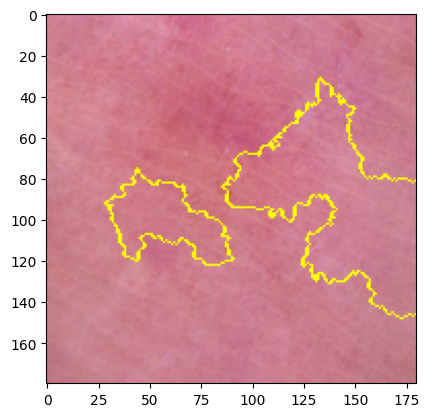

In [ ]:
from skimage.segmentation import mark_boundaries

# Load the image
fp = open("output_image4.png","rb")
img = PIL.Image.open(fp)

# Preprocess the image for the model
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

# Get the explanation for the prediction
explanation = explainer.explain_instance(img_array, model.predict, top_labels=5, hide_color=0, num_samples=1000)

# Create a visualization of the explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp / 2 + 0.5, mask)

plt.imshow(img_boundry1)
plt.show()

IMAGE 5

In [ ]:
from PIL import Image

# Open the input image
input_image = Image.open('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0000145.jpg')

# Resize the image to 256x256
output_image = input_image.resize((180, 180))

# Save the output image
output_image.save('output_image5.png')

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


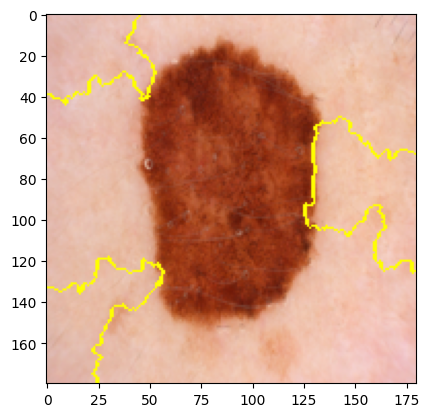

In [ ]:
from skimage.segmentation import mark_boundaries

# Load the image
fp = open("output_image5.png","rb")
img = PIL.Image.open(fp)

# Preprocess the image for the model
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

# Get the explanation for the prediction
explanation = explainer.explain_instance(img_array, model.predict, top_labels=5, hide_color=0, num_samples=1000)

# Create a visualization of the explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp / 2 + 0.5, mask)

plt.imshow(img_boundry1)
plt.show()

IMAGE 6

In [ ]:
from PIL import Image

# Open the input image
input_image = Image.open('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/ISIC_0025957.jpg')

# Resize the image to 256x256
output_image = input_image.resize((180, 180))

# Save the output image
output_image.save('output_image6.png')

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


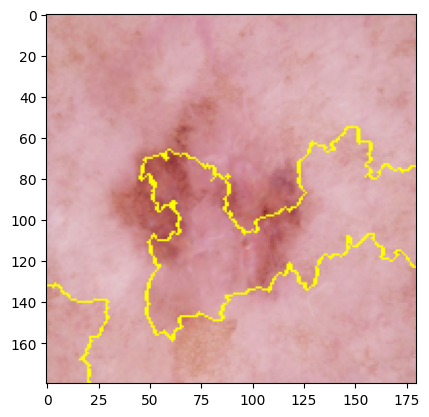

In [ ]:
from skimage.segmentation import mark_boundaries

# Load the image
fp = open("output_image6.png","rb")
img = PIL.Image.open(fp)

# Preprocess the image for the model
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

# Get the explanation for the prediction
explanation = explainer.explain_instance(img_array, model.predict, top_labels=5, hide_color=0, num_samples=1000)

# Create a visualization of the explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp / 2 + 0.5, mask)

plt.imshow(img_boundry1)
plt.show()

IMAGE 7

In [ ]:
from PIL import Image

# Open the input image
input_image = Image.open('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/ISIC_0028237.jpg')

# Resize the image to 256x256
output_image = input_image.resize((180, 180))

# Save the output image
output_image.save('output_image7.png')

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


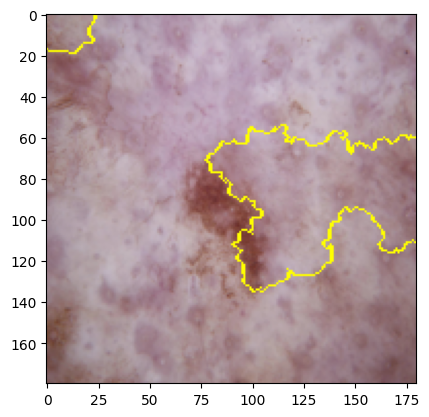

In [ ]:
from skimage.segmentation import mark_boundaries

# Load the image
fp = open("output_image7.png","rb")
img = PIL.Image.open(fp)

# Preprocess the image for the model
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

# Get the explanation for the prediction
explanation = explainer.explain_instance(img_array, model.predict, top_labels=5, hide_color=0, num_samples=1000)

# Create a visualization of the explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp / 2 + 0.5, mask)

plt.imshow(img_boundry1)
plt.show()

IMAGE 8

In [ ]:
from PIL import Image

# Open the input image
input_image = Image.open('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/ISIC_0010979.jpg')

# Resize the image to 256x256
output_image = input_image.resize((180, 180))

# Save the output image
output_image.save('output_image8.png')

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


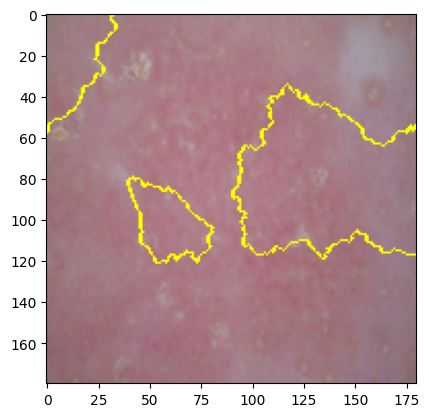

In [ ]:
from skimage.segmentation import mark_boundaries

# Load the image
fp = open("output_image8.png","rb")
img = PIL.Image.open(fp)

# Preprocess the image for the model
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

# Get the explanation for the prediction
explanation = explainer.explain_instance(img_array, model.predict, top_labels=5, hide_color=0, num_samples=1000)

# Create a visualization of the explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp / 2 + 0.5, mask)

plt.imshow(img_boundry1)
plt.show()

IMAGE 9

In [ ]:
from PIL import Image

# Open the input image
input_image = Image.open('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/ISIC_0031578.jpg')

# Resize the image to 256x256
output_image = input_image.resize((180, 180))

# Save the output image
output_image.save('output_image9.png')

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


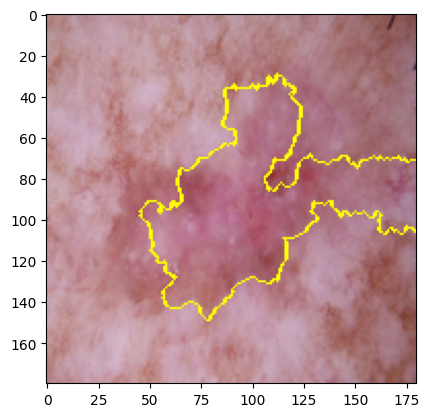

In [ ]:
from skimage.segmentation import mark_boundaries

# Load the image
fp = open("output_image9.png","rb")
img = PIL.Image.open(fp)

# Preprocess the image for the model
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

# Get the explanation for the prediction
explanation = explainer.explain_instance(img_array, model.predict, top_labels=5, hide_color=0, num_samples=1000)

# Create a visualization of the explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp / 2 + 0.5, mask)

plt.imshow(img_boundry1)
plt.show()

IMAGE 10

In [ ]:
from PIL import Image

# Open the input image
input_image = Image.open('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0025599.jpg')

# Resize the image to 256x256
output_image = input_image.resize((180, 180))

# Save the output image
output_image.save('output_image10.png')

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


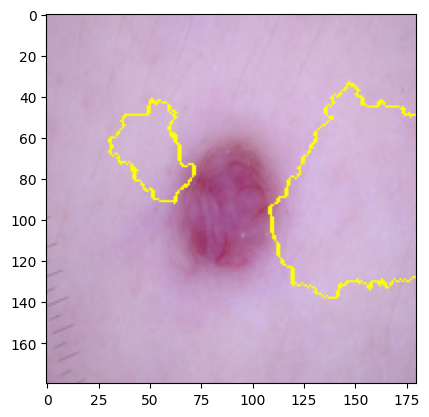

In [ ]:
from skimage.segmentation import mark_boundaries

# Load the image
fp = open("output_image10.png","rb")
img = PIL.Image.open(fp)

# Preprocess the image for the model
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

# Get the explanation for the prediction
explanation = explainer.explain_instance(img_array, model.predict, top_labels=5, hide_color=0, num_samples=1000)

# Create a visualization of the explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp / 2 + 0.5, mask)

plt.imshow(img_boundry1)
plt.show()

U-Net


In [ ]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


def unet(pretrained_weights = None,input_size = (224,224,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'softmax')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [ ]:
input_size = (224,224,3)

conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)
up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = concatenate([drop4,up6], axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2D(1, 1, activation = 'softmax')(conv9)

model.compile(optimizer = Adam(lr = 1e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

In [ ]:
#Create a file to save models
top_model_weights_path = 'model.h5'
model.save_weights(top_model_weights_path)